STREME Auswertung ist zweifelhaft
- zum einen einige Schritte zum Erstellen des Datensatzes (Referenzmotif-Familien??) und zum Erzeugen der Ergebnisse (woher Fehlerbalken??) nicht beschrieben
- zum anderen mögliche Biases durch verwendete Tools (Approximationen im Tomtom p-Value, MEME benutzt um Referenzmotive zu erzeugen, ...)


Besser auf den Rohdaten evaluieren:
- Grobe Idee: Referenzmotif-Vorkommen in Rohdaten finden
- Dann MEME bzw. ProfileFinding ihren Job machen lassen
- Diese Vorkommen wieder suchen
- Vergleichen

In [181]:
import gzip
import numpy as np
import pandas as pd
from pathlib import Path
import re

from modules import plotting

In [2]:
datadir = Path('/home/ebelm/genomegraph/data/STREME_benchmark_data/03_raw_data')

In [3]:
toolname = "fimo"

In [5]:
sitedir = datadir / 'motif_sites' / toolname

all_sites = []
for experiment in sitedir.iterdir():
    if not experiment.is_dir():
        continue

    sitef = experiment / 'fimo.tsv'
    assert sitef.exists(), str(sitef)

    experiment_name = experiment.name
    sites = pd.read_csv(sitef, sep='\t', comment='#')
    sites['experiment'] = experiment_name
    all_sites.append(sites)

all_sites = pd.concat(all_sites)
all_sites

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,experiment
0,SRF_full,NaN,chr9:114973201-114973401,101,116,+,26.34690,2.150000e-10,0.000178,TGCCCATATATGGGCA,wgEncodeAwgTfbsHaibK562SrfV0416101UniPk.narrow...
1,SRF_full,NaN,chr9:114973201-114973401,101,116,-,26.34690,2.150000e-10,0.000178,TGCCCATATATGGGCA,wgEncodeAwgTfbsHaibK562SrfV0416101UniPk.narrow...
2,SRF_full,NaN,chr16:11375217-11375417,79,94,-,24.71430,2.060000e-09,0.000852,TGCCCATATATGGACA,wgEncodeAwgTfbsHaibK562SrfV0416101UniPk.narrow...
3,SRF_full,NaN,chr8:22550942-22551165,110,125,+,24.71430,2.060000e-09,0.000852,TGCCCATATATGGACA,wgEncodeAwgTfbsHaibK562SrfV0416101UniPk.narrow...
4,SRF_full,NaN,chr16:11375217-11375417,79,94,+,24.20410,5.400000e-09,0.001490,TGTCCATATATGGGCA,wgEncodeAwgTfbsHaibK562SrfV0416101UniPk.narrow...
...,...,...,...,...,...,...,...,...,...,...,...
2813,SP4_full,NaN,chr9:130461729-130461825,40,56,-,4.32653,1.000000e-04,0.036200,GAACCCCCGCCTCCAGG,wgEncodeAwgTfbsHaibK562Sp2sc643V0416102UniPk.n...
2814,SP4_full,NaN,chr4:6202209-6202449,107,123,+,4.32653,1.000000e-04,0.036200,ACCGCCCCTCCCCCCGG,wgEncodeAwgTfbsHaibK562Sp2sc643V0416102UniPk.n...
2815,SP4_full,NaN,chr22:20118596-20118836,98,114,-,4.32653,1.000000e-04,0.036200,CCCGCCCCGCCGCCGCT,wgEncodeAwgTfbsHaibK562Sp2sc643V0416102UniPk.n...
2816,SP4_full,NaN,chr19:1205459-1205736,190,206,-,4.32653,1.000000e-04,0.036200,CCCGCCCCGCCGCCGCT,wgEncodeAwgTfbsHaibK562Sp2sc643V0416102UniPk.n...


In [7]:
motifs = all_sites['motif_id'].unique()
motifs

array(['SRF_full', 'GATA4_DBD', 'TEAD4_DBD', 'MAFF_DBD', 'EGR1_DBD',
       'ELK1_DBD_2', 'CTCF_full', 'ATF4_DBD', 'USF1_DBD', 'ETS1_DBD_1',
       'BHLHE41_full', 'NFE2_DBD', 'GATA3_DBD', 'ELF1_DBD', 'E2F7_DBD',
       'YY1_full', 'MAX_DBD_2', 'IRF9_full', 'RFX5_DBD_2', 'MEF2A_DBD',
       'SP1_DBD', 'IRF8_full', 'NR2F1_DBD_3', 'CEBPB_full', 'ZBTB7A_DBD',
       'ATF7_DBD', 'ZNF143_DBD', 'NRF1_full', 'SP4_full'], dtype=object)

In [21]:
# parse reference motif PWMs
ref_motif_f = datadir / "jolma2013.meme"
assert ref_motif_f.exists(), str(ref_motif_f)
ref_motifs = {}
with open(ref_motif_f) as f:
    alphabet_seen = False
    motif_name_seen = False
    motif_started = False
    motif_finished = True
    motif_site = None
    for line in f:
        line = line.strip()
        if line.startswith('ALPHABET'):
            m = re.match(r'ALPHABET= ([A-Z]+)', line)
            assert m, line
            alphabet = m.group(1)
            assert alphabet == 'ACGT', alphabet
            alphabet_seen = True

        if line.startswith('MOTIF'):
            assert alphabet_seen, line
            assert motif_finished, line
            assert motif_site is None, line
            motif_id = line.split()[1]
            motif_name_seen = True
            motif_started = False
            motif_finished = False

            if motif_id not in motifs:
                # reset flags to skip to next motif
                motif_name_seen = False
                motif_started = False
                motif_finished = True

        if motif_name_seen:
            if line.startswith('letter-probability matrix'):
                m = re.match(r'letter-probability matrix: alength= 4 w= (\d+).+', line)
                assert m, line
                motif_length = int(m.group(1))
                motif = np.zeros((motif_length, 4))
                motif_started = True
                motif_site = 0
            else:
                if not motif_started:
                    continue
                elif motif_started and re.match(r'^\s*$', line):
                    # done parsing motif, reset flags
                    motif_name_seen = False
                    motif_started = False
                    motif_finished = True
                    motif_site = None
                    ref_motifs[motif_id] = motif
                else:
                    assert motif_site is not None, line
                    motif[motif_site] = list(map(float, line.split()))
                    motif_site += 1


In [15]:
for motif in motifs:
    motif_sites = all_sites[all_sites['motif_id'] == motif]
    # calculate for each site stop - start
    sitelen = motif_sites['stop'] - motif_sites['start'] + 1
    print(f"{motif=}\t{sitelen.mean()=} ({sitelen.std()=}) | ({sitelen.min()=}, {sitelen.max()=})")

motif='SRF_full'	sitelen.mean()=16.0 (sitelen.std()=0.0) | (sitelen.min()=16, sitelen.max()=16)
motif='GATA4_DBD'	sitelen.mean()=8.0 (sitelen.std()=0.0) | (sitelen.min()=8, sitelen.max()=8)
motif='TEAD4_DBD'	sitelen.mean()=10.0 (sitelen.std()=0.0) | (sitelen.min()=10, sitelen.max()=10)
motif='MAFF_DBD'	sitelen.mean()=15.0 (sitelen.std()=0.0) | (sitelen.min()=15, sitelen.max()=15)
motif='EGR1_DBD'	sitelen.mean()=14.0 (sitelen.std()=0.0) | (sitelen.min()=14, sitelen.max()=14)
motif='ELK1_DBD_2'	sitelen.mean()=10.0 (sitelen.std()=0.0) | (sitelen.min()=10, sitelen.max()=10)
motif='CTCF_full'	sitelen.mean()=17.0 (sitelen.std()=0.0) | (sitelen.min()=17, sitelen.max()=17)
motif='ATF4_DBD'	sitelen.mean()=13.0 (sitelen.std()=0.0) | (sitelen.min()=13, sitelen.max()=13)
motif='USF1_DBD'	sitelen.mean()=10.0 (sitelen.std()=0.0) | (sitelen.min()=10, sitelen.max()=10)
motif='ETS1_DBD_1'	sitelen.mean()=10.0 (sitelen.std()=0.0) | (sitelen.min()=10, sitelen.max()=10)
motif='BHLHE41_full'	sitelen.mean()=

All site matches have the same lengths

/home/ebelm/genomegraph/.venv/lib/python3.10/site-packages/logomaker/src/Logo.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=self.figsize)


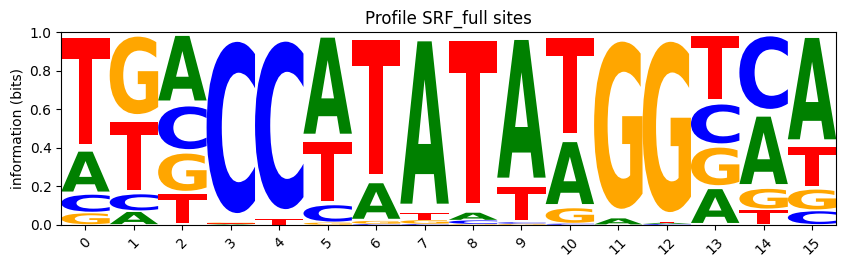

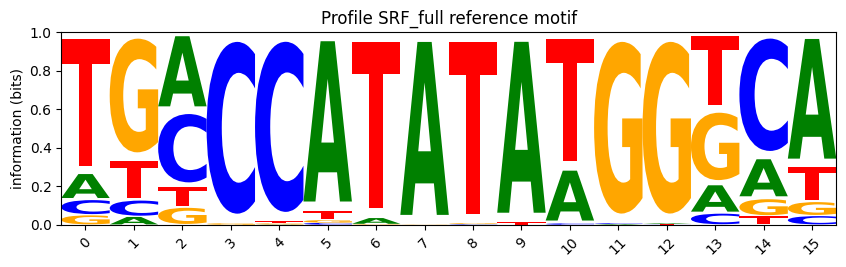

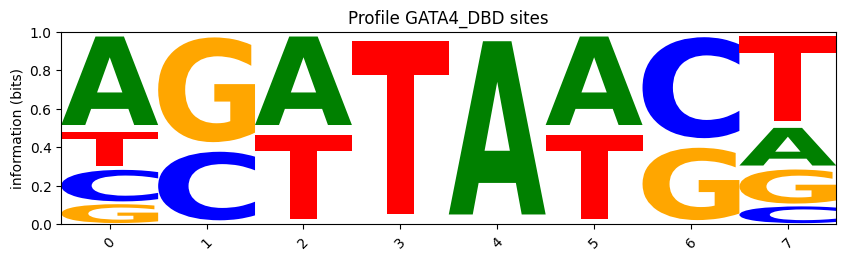

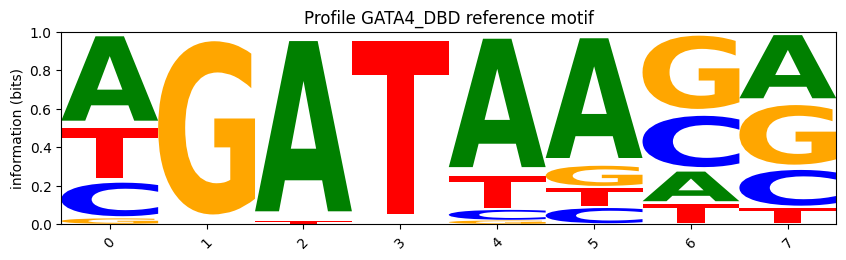

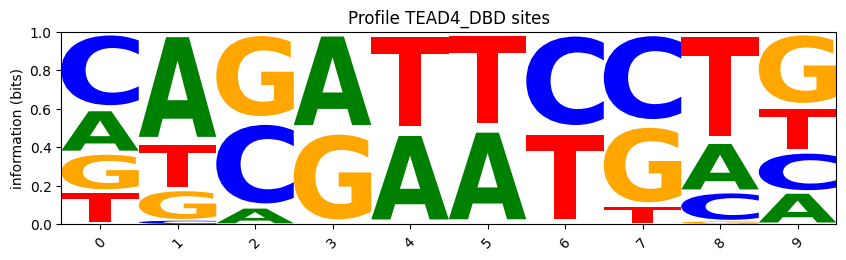

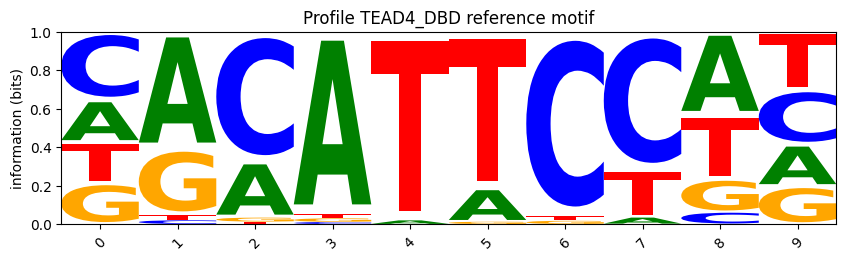

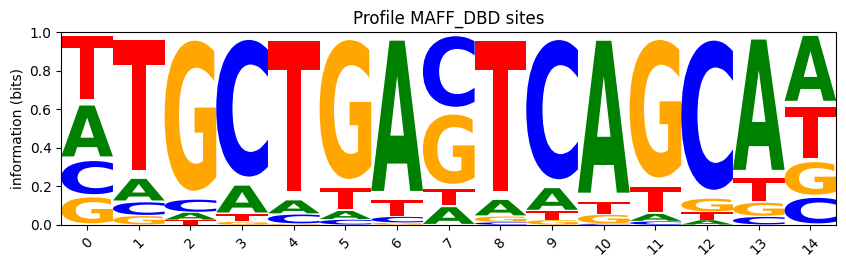

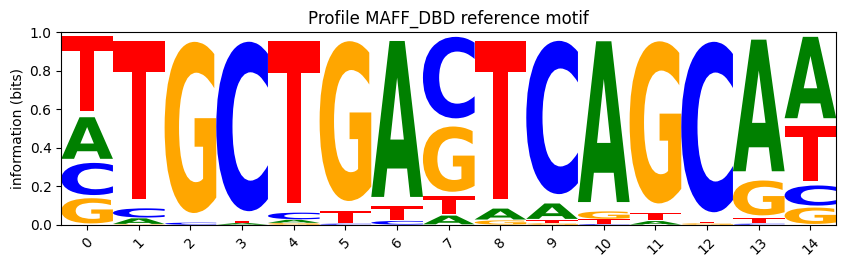

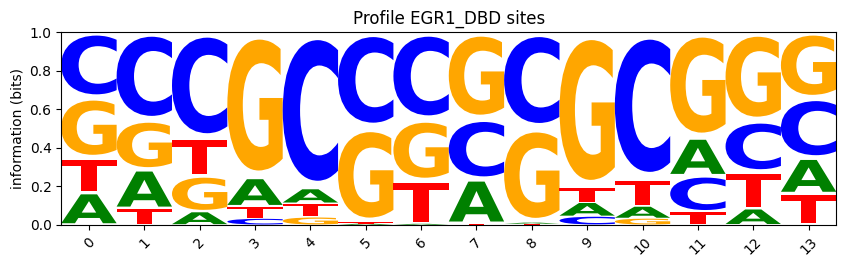

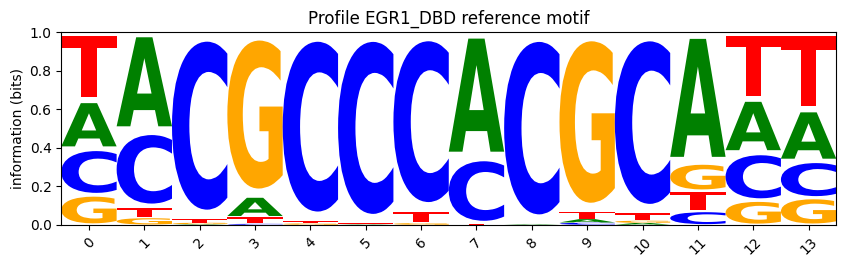

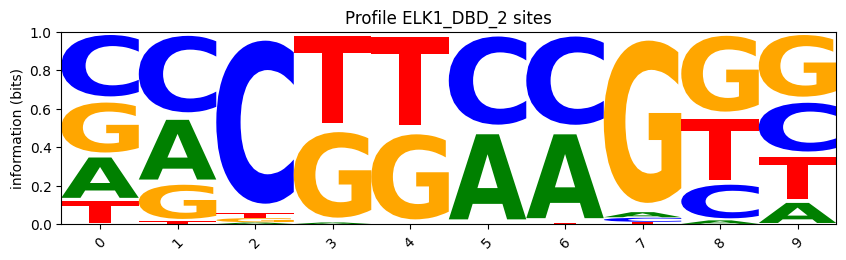

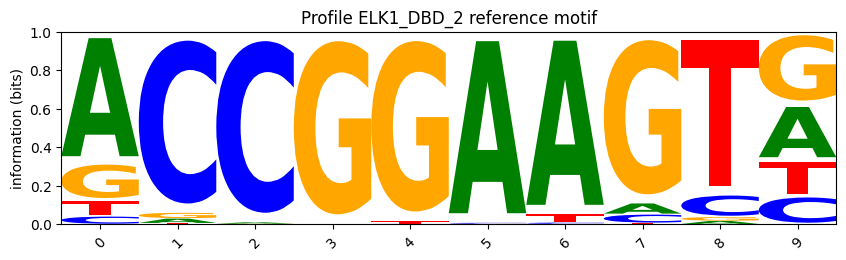

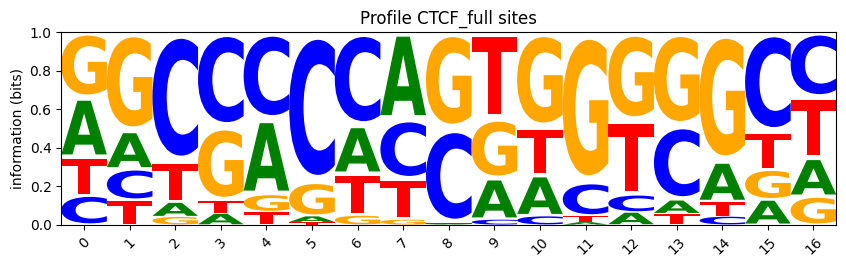

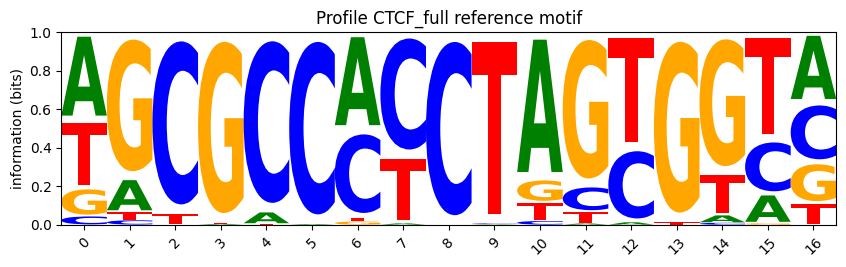

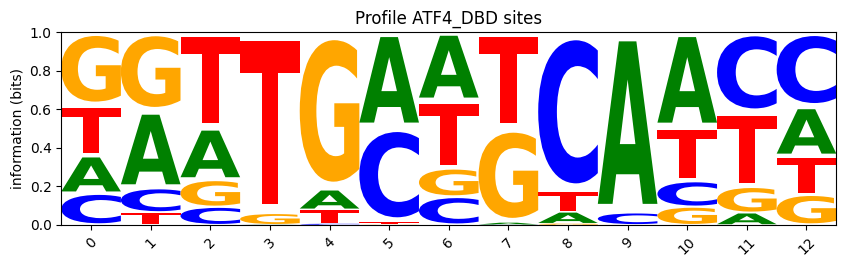

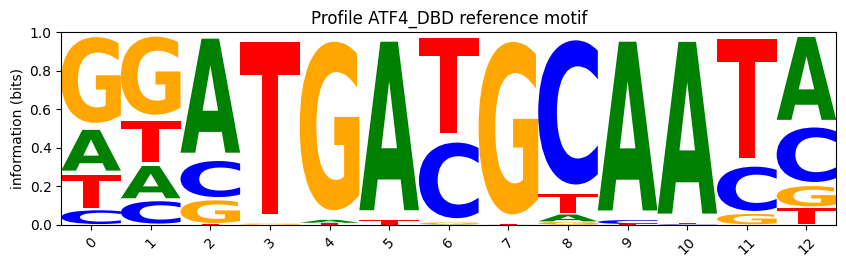

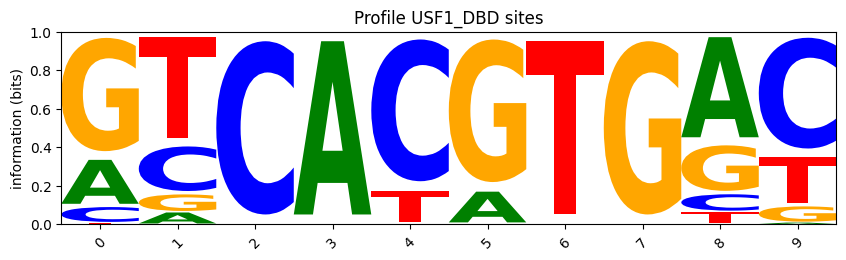

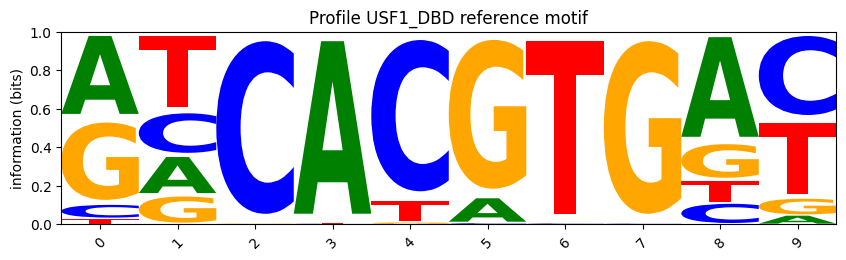

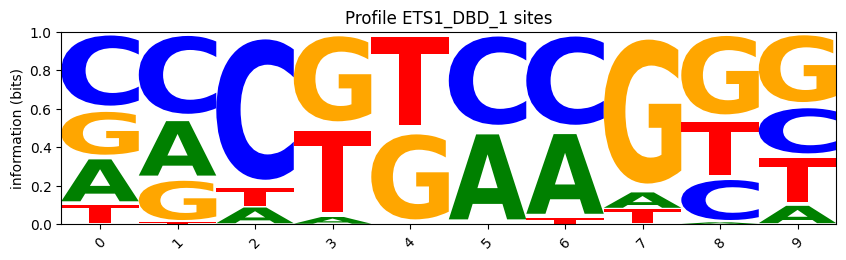

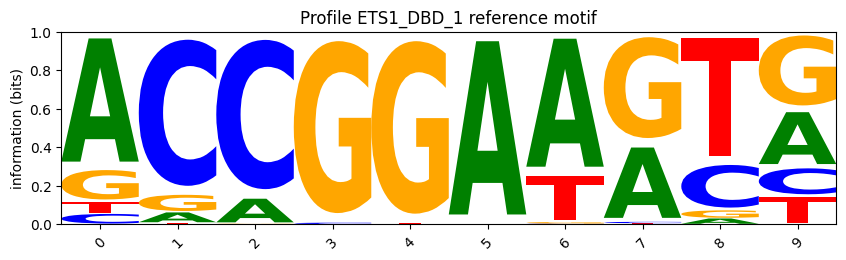

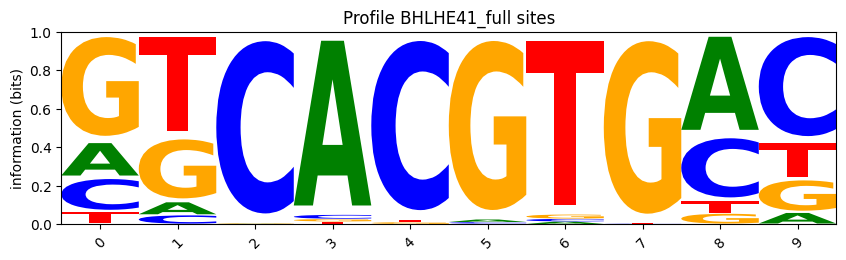

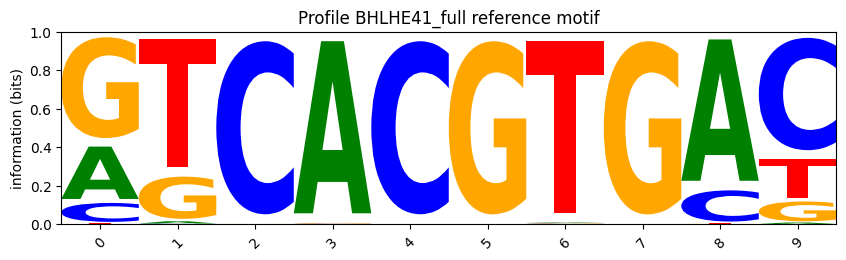

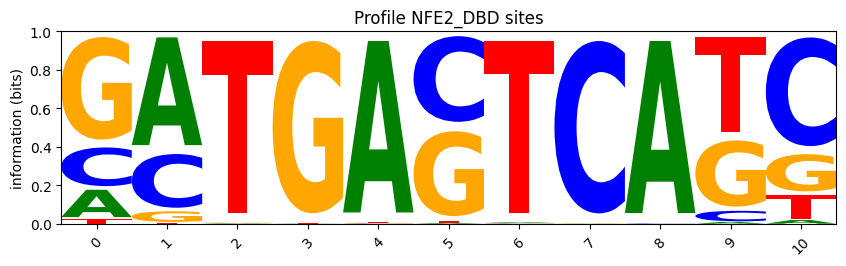

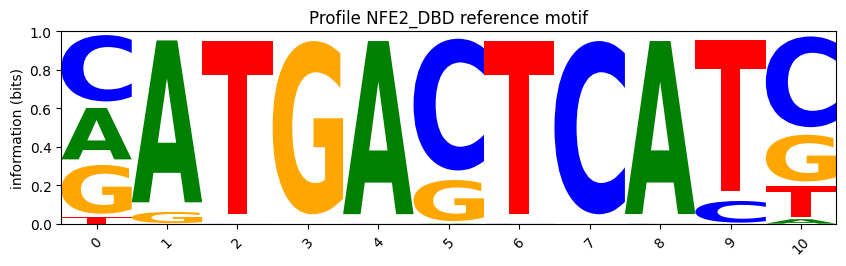

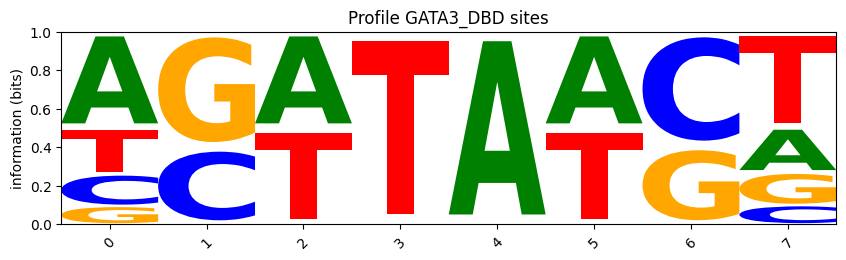

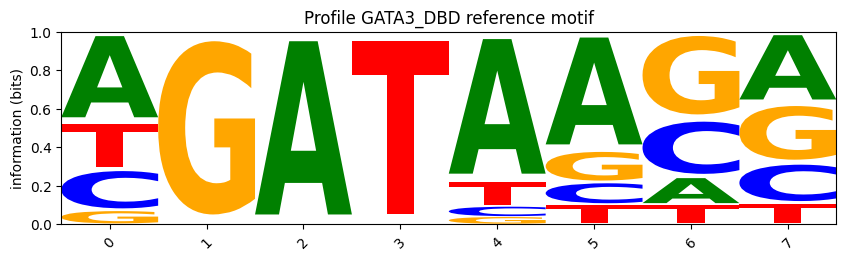

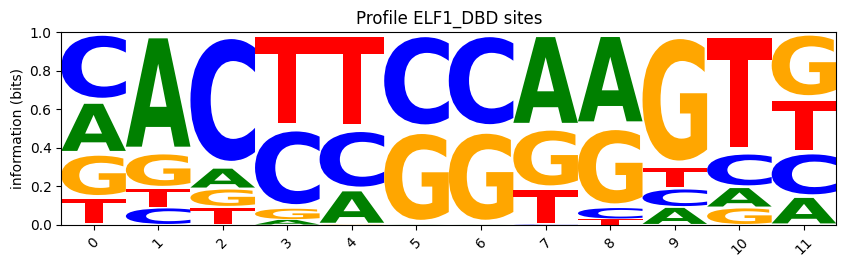

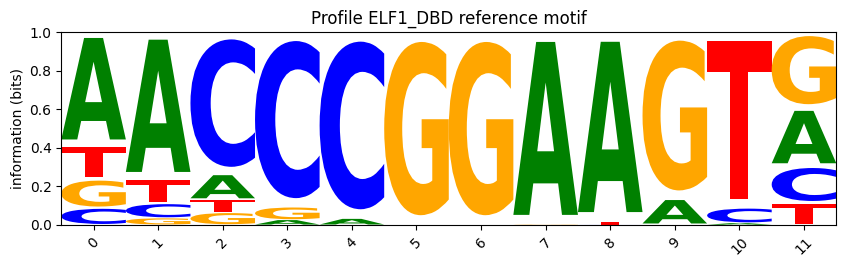

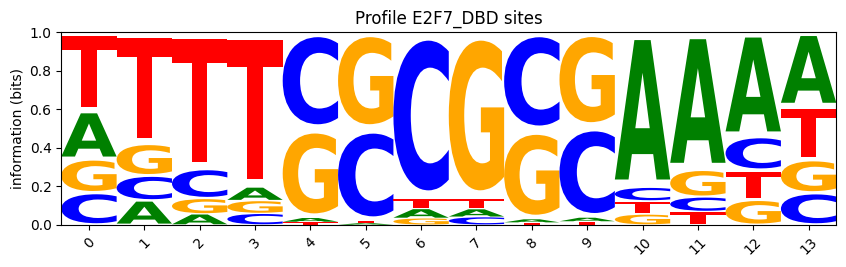

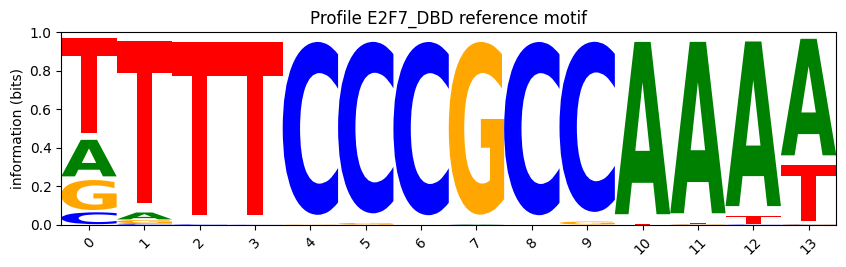

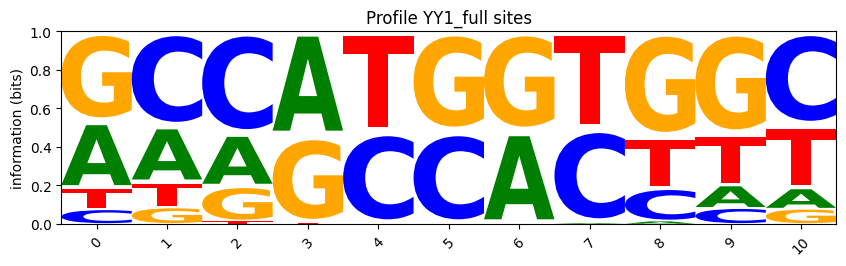

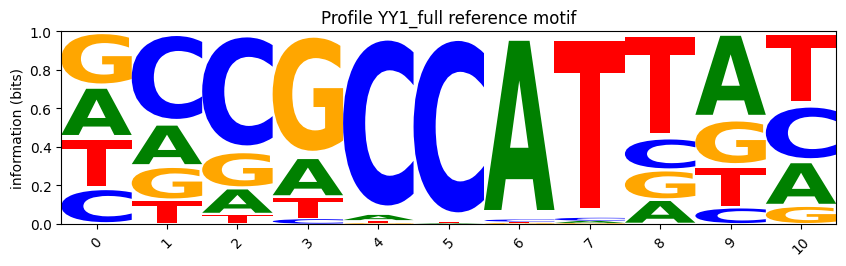

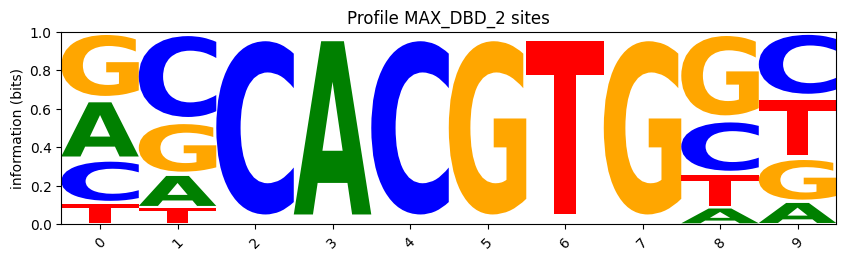

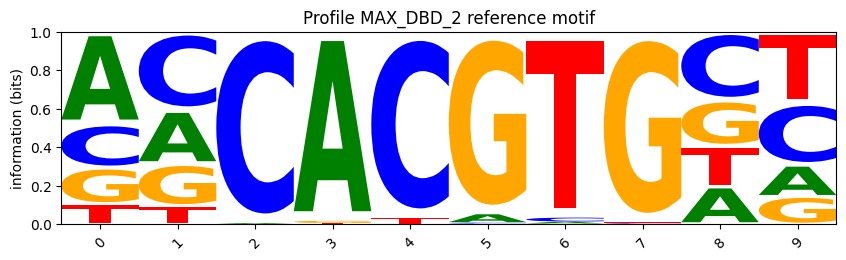

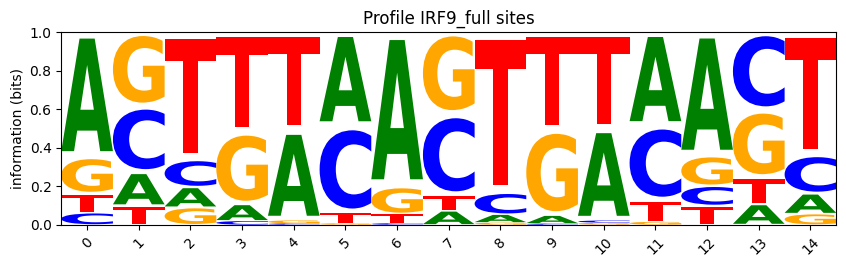

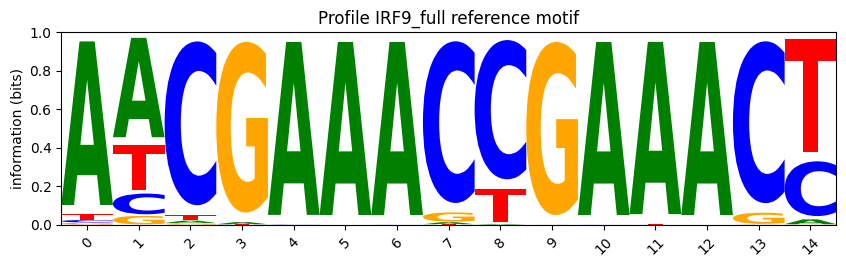

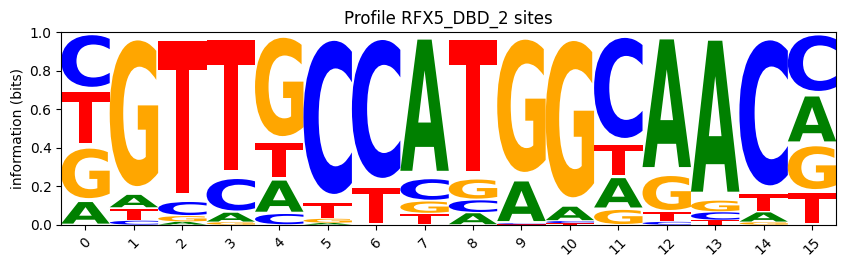

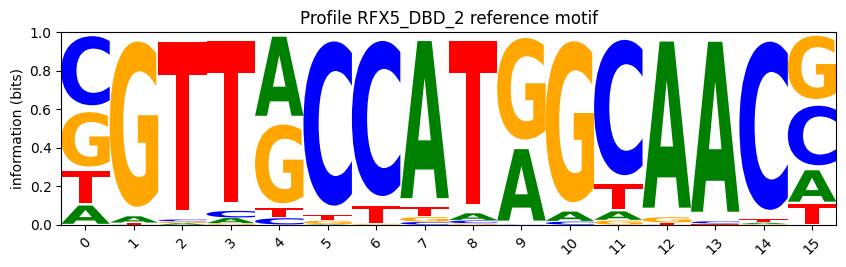

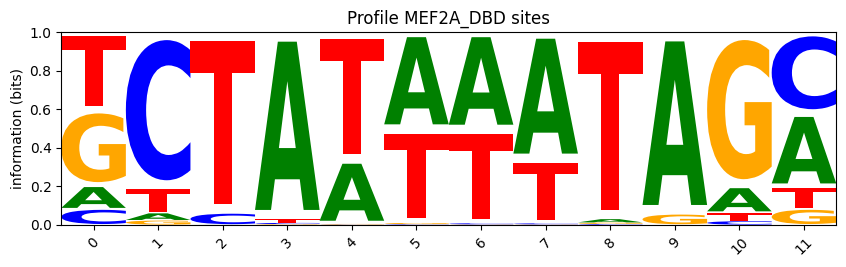

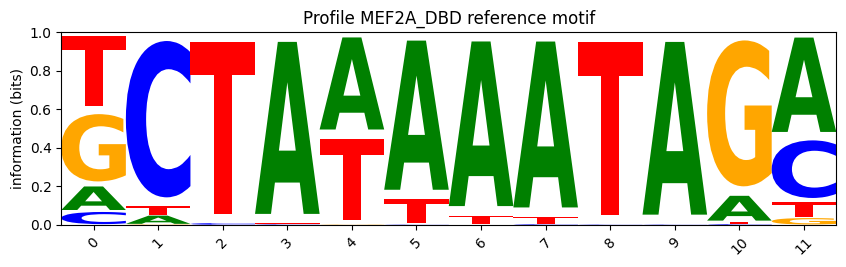

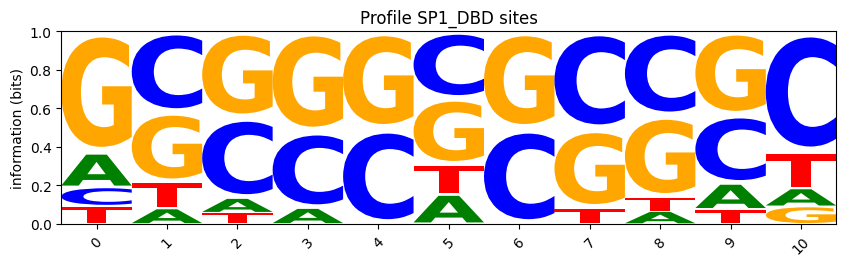

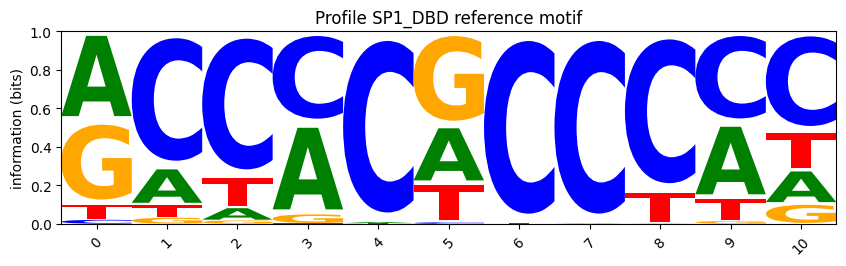

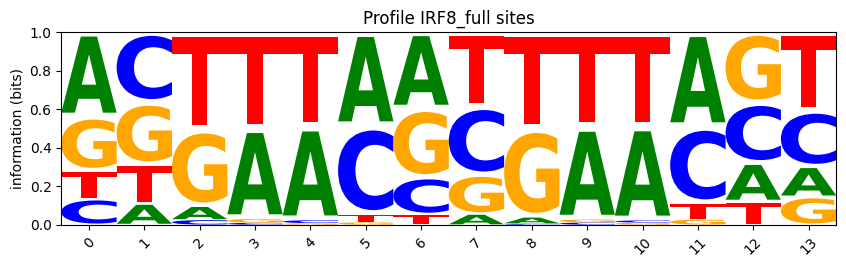

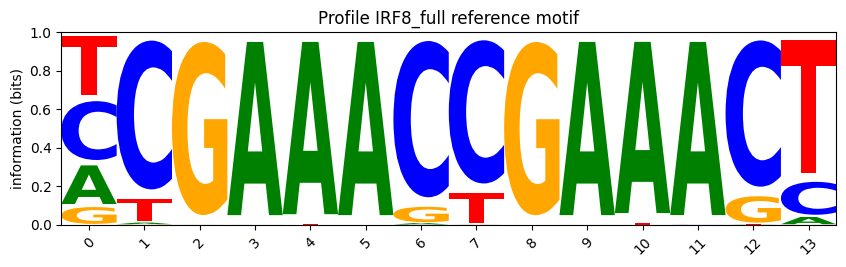

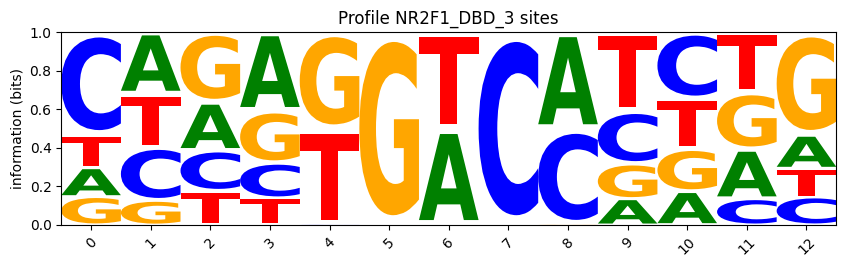

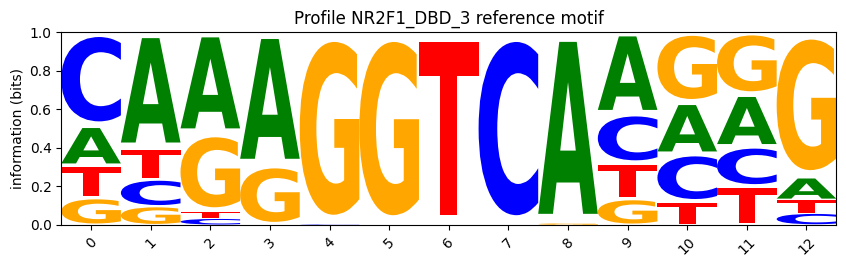

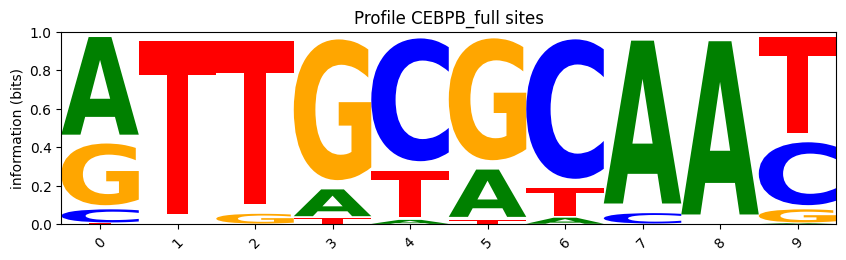

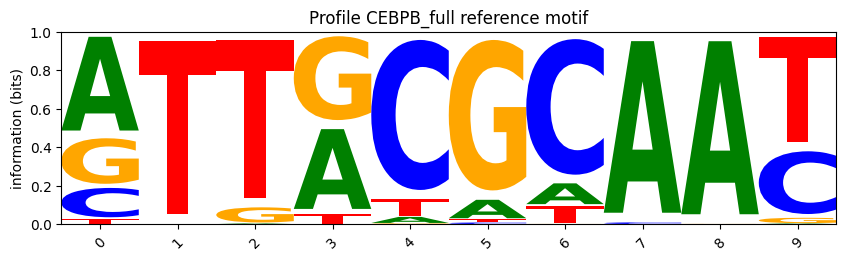

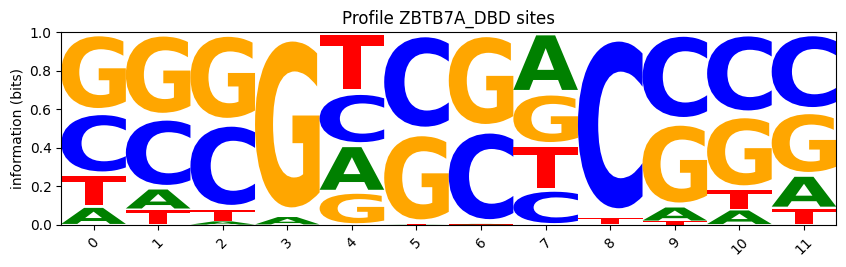

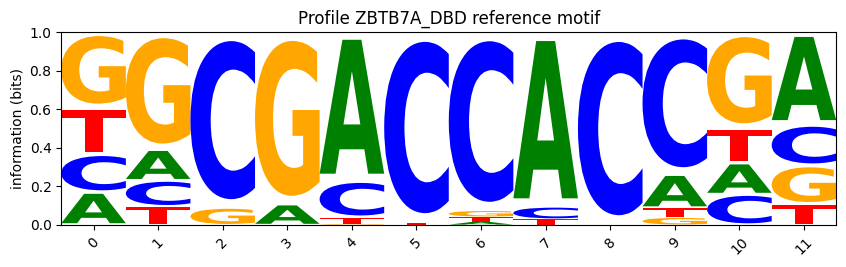

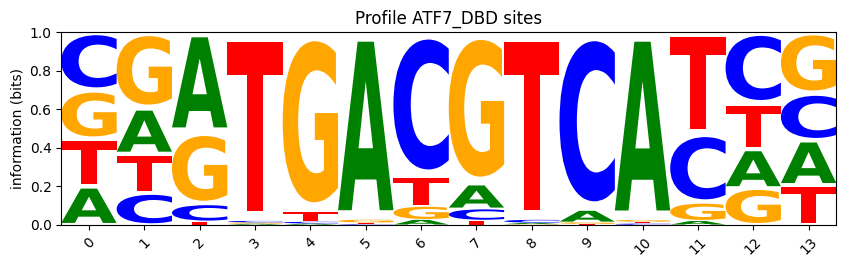

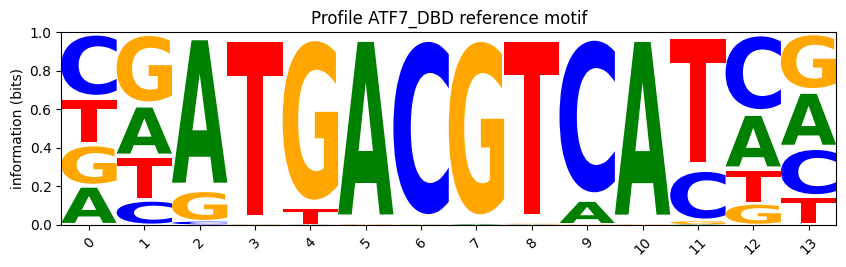

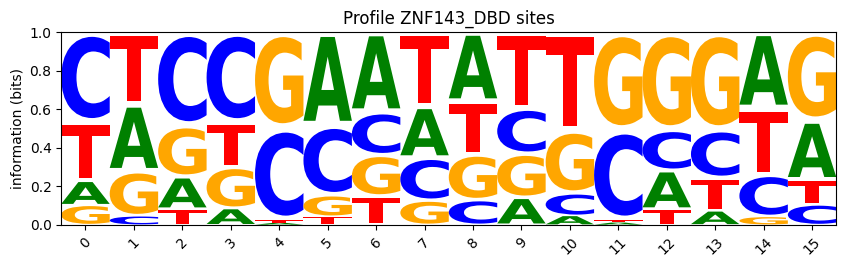

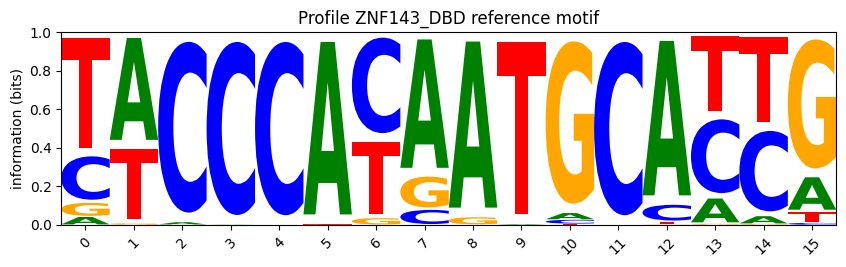

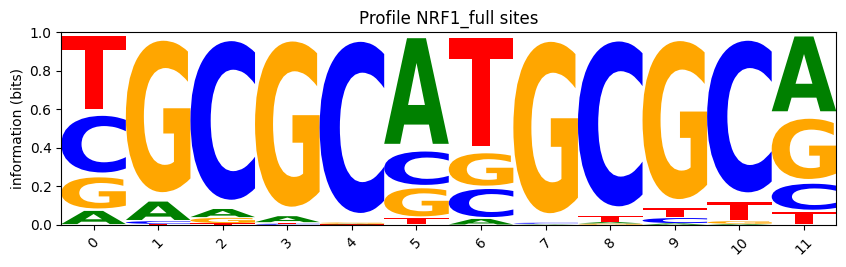

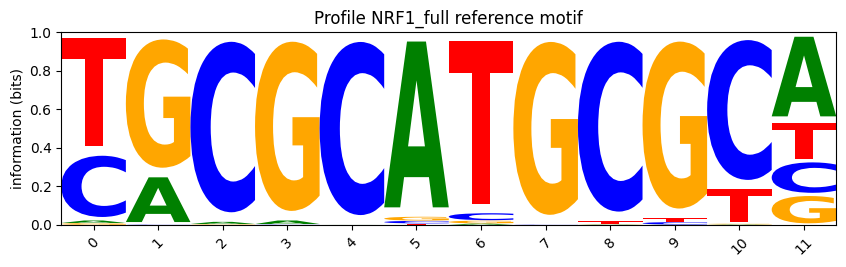

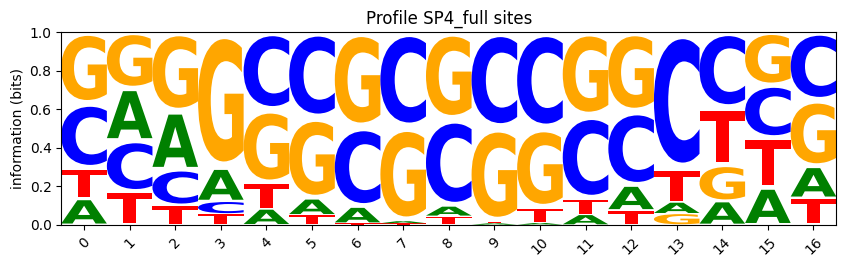

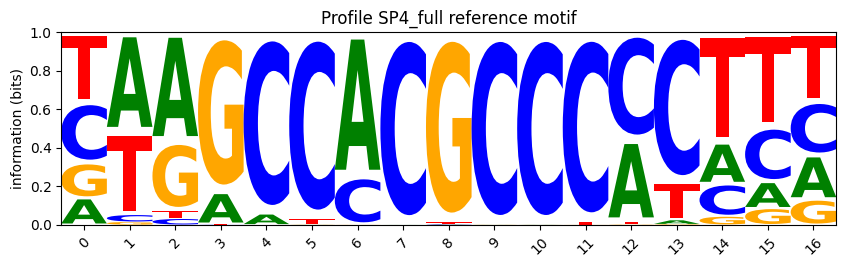

In [42]:
for motif in motifs:
    nsites = all_sites[all_sites['motif_id'] == motif].shape[0]
    _line = all_sites[all_sites['motif_id'] == motif].iloc[0]
    sitelen = _line['stop'] - _line['start'] + 1
    alphabet = ['A', 'C', 'G', 'T']
    pwm = np.zeros((sitelen, 4))
    for _, line in all_sites[all_sites['motif_id'] == motif].iterrows():
        siteseq = line['matched_sequence']
        if line['strand'] == '-':
            siteseq = siteseq[::-1].translate(str.maketrans('ACGT', 'TGCA'))
        #print(f"{siteseq=} ({len(siteseq)=}/{sitelen=})")
        for i, base in enumerate(siteseq.upper()):
            #print(base)
            pwm[i, alphabet.index(base)] += 1

    pwm = pwm / nsites
    #print(f"{motif=}\n{pwm.shape=}\n{ref_motifs[motif].shape=}")
    plotting.plotLogo(np.concatenate([np.expand_dims(pwm, -1), 
                                      np.expand_dims(ref_motifs[motif], -1)], axis=2), 
                      alphabet, pNames=[f"{motif} sites", f"{motif} reference motif"],)
    plottint.plt.close()

---

Per motif, per experiment: share of sequences that contain the reference motif

In [150]:
site_occs = {}
for motif in motifs:
    site_occs[motif] = {}
    motif_sites = all_sites[all_sites['motif_id'] == motif]
    for experiment in motif_sites['experiment'].unique():
        site_occs[motif][experiment] = {}
        motif_sites_exp = motif_sites[motif_sites['experiment'] == experiment]
        for seq in motif_sites_exp['sequence_name'].unique():
            site_occs[motif][experiment][seq] = motif_sites_exp[motif_sites_exp['sequence_name'] == seq].shape[0]

In [161]:
# load experiment fastas and add sequences without any sites to the site_occs dict
exp_to_motif = pd.read_csv(datadir / "target_reference_motifs.tsv", sep='\t', names=['experiment', 'motif'])
for fasta in (datadir / "peakfastas").iterdir():
    if not fasta.is_file():
        continue
    experiment = Path(fasta.stem).stem
    motif = exp_to_motif[exp_to_motif['experiment'] == experiment]['motif'].values[0]
    print(f"Processing {motif} / {experiment}")
    assert motif in site_occs, f"{motif=}, {experiment=}"
    assert experiment in site_occs[motif], f"{motif=}, {experiment=}"
    
    with open(fasta) as f:
        for line in f:
            if line.startswith('>'):
                seq = line.strip()[1:]
                # print(f"{seq=}")
                if seq not in site_occs[motif][experiment]:
                    site_occs[motif][experiment][seq] = 0

Processing USF1_DBD / wgEncodeAwgTfbsHaibK562Usf1V0416101UniPk.narrowPeak
Processing BHLHE41_full / wgEncodeAwgTfbsSydhK562Bhlhe40nb100IggrabUniPk.narrowPeak
Processing SP4_full / wgEncodeAwgTfbsHaibK562Sp2sc643V0416102UniPk.narrowPeak
Processing CEBPB_full / wgEncodeAwgTfbsSydhK562CebpbIggrabUniPk.narrowPeak
Processing TEAD4_DBD / wgEncodeAwgTfbsHaibK562Tead4sc101184V0422111UniPk.narrowPeak
Processing YY1_full / wgEncodeAwgTfbsHaibK562Yy1V0416102UniPk.narrowPeak
Processing NRF1_full / wgEncodeAwgTfbsSydhK562Nrf1IggrabUniPk.narrowPeak
Processing SRF_full / wgEncodeAwgTfbsHaibK562SrfV0416101UniPk.narrowPeak
Processing SP1_DBD / wgEncodeAwgTfbsHaibK562Sp1Pcr1xUniPk.narrowPeak
Processing MAFF_DBD / wgEncodeAwgTfbsSydhK562MaffIggrabUniPk.narrowPeak
Processing IRF8_full / wgEncodeAwgTfbsSydhK562Irf1Ifna6hUniPk.narrowPeak
Processing NR2F1_DBD_3 / wgEncodeAwgTfbsHaibK562Nr2f2sc271940V0422111UniPk.narrowPeak
Processing GATA4_DBD / wgEncodeAwgTfbsSydhK562Gata1UcdUniPk.narrowPeak
Processing ZBTB

Text(0.5, 0, 'Number of motif sites per sequence')

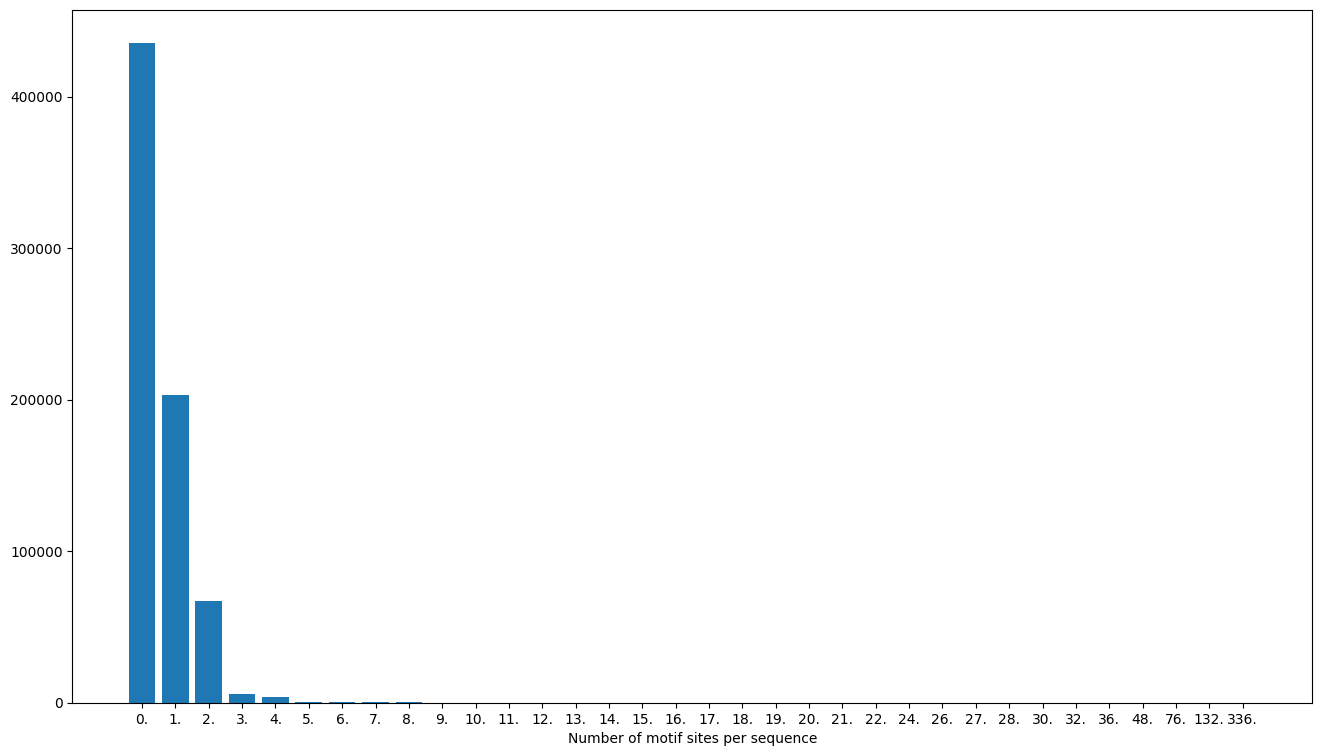

In [187]:
# histogram of site occurences per sequence
site_counts_per_seq = []
for motif in motifs:
    for experiment in site_occs[motif]:
        for seq in site_occs[motif][experiment]:
            site_counts_per_seq.append(site_occs[motif][experiment][seq])

#plotting.ownPlotlyHist({'sites per seq': site_counts_per_seq}, bins=range(0, max(site_counts_per_seq)+1))
_bins, _vals = plotting.ownHist(site_counts_per_seq, bins=range(0, max(site_counts_per_seq)+1))
bins = []
vals = []
for i in _bins:#range(len(_bins)):
    if _vals[i] != 0:
        bins.append(_bins[i])
        vals.append(_vals[i])

fig, ax = plotting.plotOwnHist(bins, vals)
ax.set_xlabel('Number of motif sites per sequence')

In [174]:
n = len(site_counts_per_seq)
no_sites = sum([1 for i in range(n) if site_counts_per_seq[i] == 0])

print(f"{no_sites}/{n} = {no_sites/n*100:.2f}% of sequences have no motif occurrences according to {toolname}")

435596/717502 = 60.71% of sequences have no motif occurrences according to fimo


---

Motif occurrence position distribution

(<Figure size 1600x900 with 1 Axes>, <Axes: >)

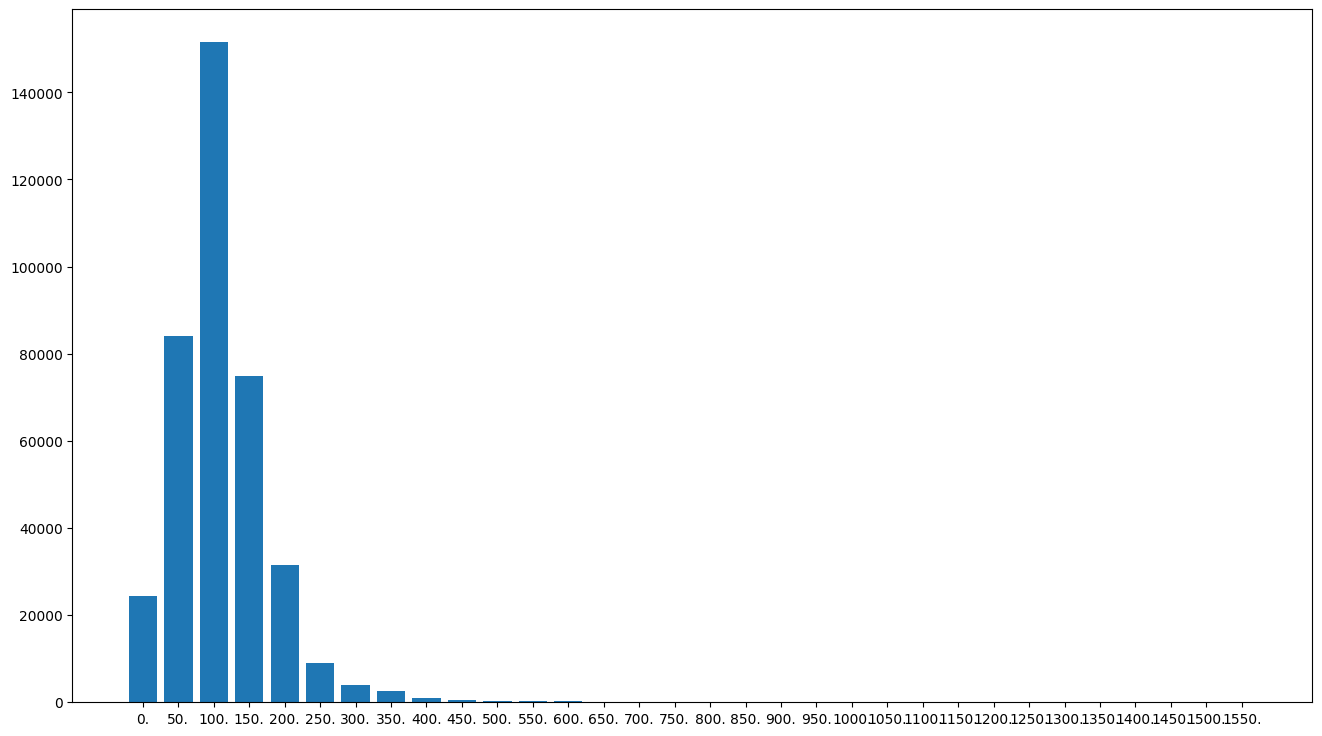

In [180]:
positions = []
for _, line in all_sites.iterrows():
    len = line['stop'] - line['start'] + 1
    pos = line['start'] + len // 2
    positions.append(pos)

#bins, vals = plotting.ownHist(positions, bins=range(min(positions), max(positions)+1))
bins, vals = plotting.ownHist(positions, binSize=50)
plotting.plotOwnHist(bins, vals)

In [ ]:
# # parse detailed sequence information from BED files
# seq_info = {}
# for bedfile in (datadir / "narrowPeakFiles").iterdir():
#     if not bedfile.is_file():
#         continue
#     experiment = bedfile.stem
#     print(f"Processing {experiment}")
#     seq_info[experiment] = {}
#     with gzip.open(bedfile) as f:
#         for line in f:
#             line = line.strip().split()
#             seq = f"{line[0]}:{line[1]}-{line[2]}"
#             start = int(line[1])
#             end = int(line[2])
#             seq_info[experiment][seq] = {'start': start, 'end': end}

Text(0.5, 0, 'Position relative to sequence center')

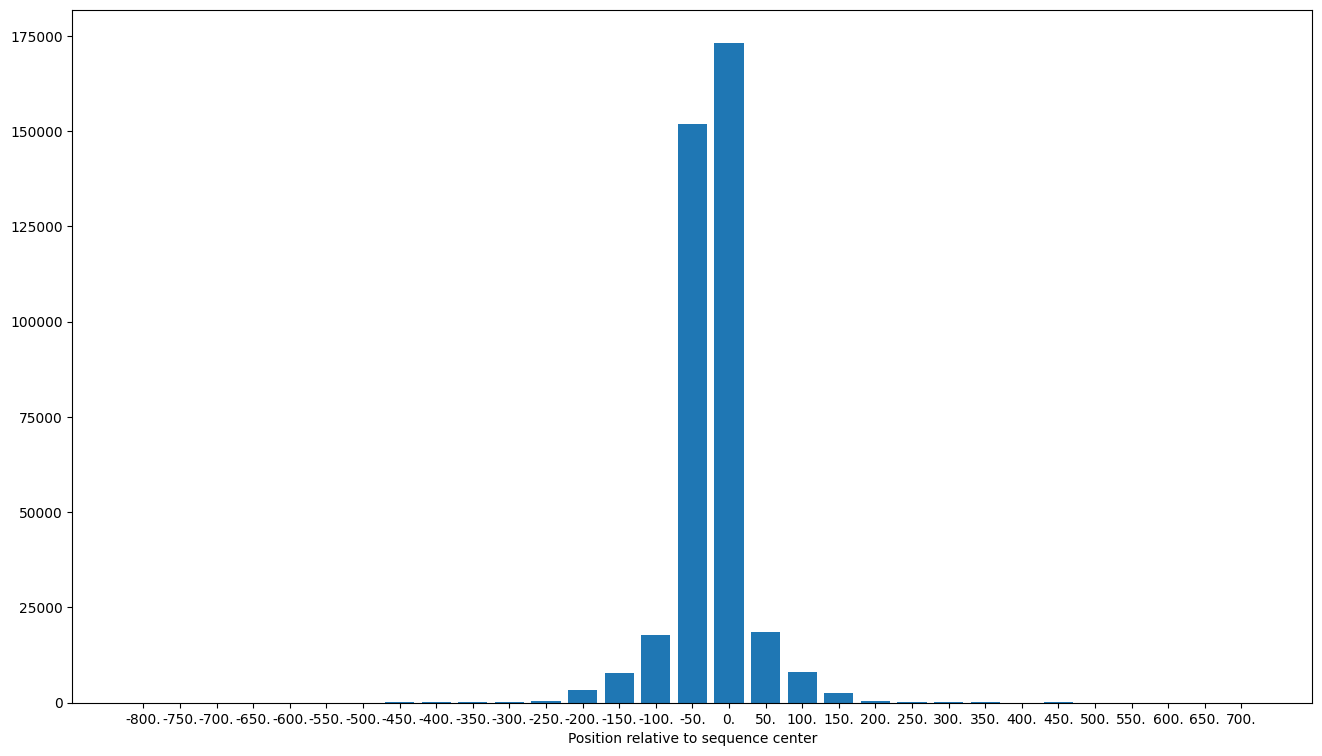

In [184]:
# offset from sequence center
positions = []
for _, line in all_sites.iterrows():
    seq = line['sequence_name']
    seqstart, seqend = seq.split(':')[1].split('-')
    seqstart = int(seqstart)
    seqend = int(seqend) + 1
    seqlen = seqend - seqstart
    seqcenter = seqlen // 2

    sitelen = line['stop'] - line['start'] + 1
    pos = line['start'] + sitelen // 2
    positions.append(pos-seqcenter)

bins, vals = plotting.ownHist(positions, binSize=50)
fig, ax = plotting.plotOwnHist(bins, vals)
ax.set_xlabel('Position relative to sequence center')